<center><h1 style="font-size: 48px;">Modelling Wildfire Risk <em>in</em> Random Forests</h1></center>

## <center>A Policy-Oriented Tool for Managing South African Wildfires<center>
<img src="SABC-News-Knysna-Fire-Tanya-Krause.jpg" alt="Alt text" style="width: 100%;">

#### <center>By Anonymous<center>

# A Note from the Editor
"_June 7th, 2017. Gale-force winds whipped through the Garden Route, reaching speeds likened to a hurricane—a phenomenon not previously witnessed in the Southern Cape. By 6 AM in the morning, local Fire officials were alerted to a fire just East of Knysna. Given the conditions, this fire alone would have been near impossible to control. Knynsa has but two exits, the N2 East towards Plett, and the N2 West towards George. By midday, the Elandskraal fire to the West had completely cut off all escape_.

_As the fight against the fires continued, a massive contingent of nearly 1,200 firefighters from various corners of the country converged upon Knysna. The fires lasted days, with the rural farm lands dealing with re-ignitions for weeks. The aftermath of the fires was sobering, with seven lives lost, 10 000 people left without homes, and with over 4 Billion Rands of estimated damage. The Knysna fires of June 2017 stands as the worst wildfire disaster in South African history_.

_I would know - I was there. For over a week I had helped fight back against the fires that had enveloped my local farm community, alongside my father, Deon van Zyl, a chairperson of the Southern Cape Fire Protection Association. I'm well aquainted with the dangers that wildfires impose, and having bore witness to the constant frustrations of my father, I also know that there is still much work to be done to ensure that Knysna 2017 doesn't happen again._" 




# Table of Contents
1. [Introduction](#introduction)
2. [Pipeline Overview](#pipeline)
3. [Data and Preparation](#data)

    3.1 [MODIS Fire_cci v5.1 Pixel Product](#modis)
    
    3.2 [Humanitarian Data Exchange Population Map](#pop)
    
    3.3 [Historical Climate Data](#climate)
    
    3.4 [Köppen–Geiger Map](#koppen)
    
    3.5 [Meteostat Weather Data](#weather)
    
    3.6 [SANBI National Vegetation Map Project (VEGMAP)](#veg)
    
    3.7 [Topology Dataset](#top)
    
    3.8 [ESA Above Ground Biomass](#agb)
    
4. [Methodology](#methods)

    4.1 [Fire Predisposition](#fire_pre)
    
    4.2 [Burned Area](#fire_area)
    
5. [Results](#results)

    5.1 [Predisposition Model](#results1)
    
    5.2 [Burned Area Model](#results2)

6. [A Retrospective and the Way Forward](#forward)

In [1]:
# Include necessary imports and constant variables
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import rasterio
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry import box
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import xgboost as xgb
from catboost import CatBoostRegressor, Pool, cv

# 1. Introduction <a class="anchor" id="introduction"></a>
South Africa's unique biodiversity is a national wonder. However, the chracteristics of our beautiful landscapes lend themselves to the increasing prescence of wildfires, exacerbated by climate change. Effective wildfire modeling has thus become an essential tool in the country's environmental strategy. Wildfire modelling is a wide field, with work in modelling active fires as well as modelling fire 'risk.'

The risk modelling system employed in South Africa is the Fire Danger Index (FDI): a system to assess the risk of fire in a particular area on a given day. The FDI is calculated using solely weather and climate factors such as temperature (in °C), relative humidity (with lower moisture indicating higher risk), wind speed (where higher speeds increase risk), and previous rainfall (considering the amount and recency, but not future rainfall despite expected humidity levels). These factors are assigned values that contribute to a cumulative score, which is then classified into a color-coded risk category ranging from blue (safe) to red (extreme danger), guiding activities and precautions related to fire. However, the FDI therefore does not take into account some of the other most critical factors associated with fire risk, including vegetation, density of fuel source and topography.

Long-term fire risk assessments have been conducted by entities such as the Council for Scientific and Industrial Research (CSIR) and insurance firms like SANTAM. These assessments adopt a comprehensive approach, taking into account a broad spectrum of climatic and environmental factors. However, the underlying data driving these assessments are often proprietary, and the rationale for regional risk categorization lacks full transparency. Furthermore, challenges arise due to the variable nature of fire risk within even small geographical areas, which can display significantly divergent vulnerabilities to fire. Traditional models tend to employ averages, which may result in an area being classified as medium risk even if it contains both high and low-risk zones, thereby potentially underestimating the potential for damage. Additionally, these models predominantly rely on historical fire distribution data, leading to the oversight of areas that, despite not having experienced frequent fires, should be considered at risk.

In pursuit of a more targeted approach to fire risk assessment, we have developed a novel methodology. Our models are agnostic to the specific region under consideration (we ignore where the region is) and evaluate fire risk based solely on environmental and meteorological factors. The models are presented with various snapshots of South African regions (5kmx5km) — a "Random Forest"— with the intent of predicting fire vulnerabillity and potential severity based on historical fire data from similar environments. Our approach seperates 'risk' into two components: the likelihood of fire occurrence and the potential extent of a fire, should one ignite. By operating on different temporal scales, the models analyze both general susceptibility and the immediate risk posed by a specific fire event.

These models integrate key indicators such as vegetation density, topography, climate patterns, weather conditions, population density, and above-ground biomass. Our datasets have been sourced from a number of key organizations including the European Space Agency (ESA), and The Centre for Environmental Data Analysis (CEDA). We leverage conventional Geographic Information System (GIS) analysis tools and techniques, utilizing rasterized GeoTIFF file formats with build in map projection transformations. Collectively, these models not only serve as predictive tools but also aim to provide transparency on the significance of various features, thereby offering a clear and detailed picture of the composite factors that delineate the most vulnerable environments. Our methodology is intended to enhance wildfire management policies and foster a deeper understanding of the multifaceted nature of wildfire risk.

# 2. Pipeline Overview <a class="anchor" id="pipeline"></a>

Our code repository contains two predominant folders, `data` and `src`. `data` contained both the raw data collected and used to create our final datasets as well as the final datasets used for modelling. However, only the final datasets were included in the cloud repository due to exceedingly large file sizes. Our `src` folder contains the code that we used to collect, process, compile and model our data. The sections of the pipeline are determined by the code prefix of each file. The sections, as well as a brief description of each component are given:

- **Utility Files:**
  - `00_vegetation.ipynb`: Utility functions for vegetation data manipulation.
  - `00_view_merged_tif.ipynb`: Utility for visualizing merged TIFF geospatial files (when the files have multiple layers/bands)
  - `00_view_tif.ipynb`: Utility for visualizing individual TIFF geospatial files.

- **Data Collection Files:**
  - `01_weather_collection.ipynb`: Gathers meteorological data from the Meteostat database using the Meteostat API

- **Data Processing Files:**
  - `02_biomass.ipynb`: Processes biomass data, combining the various subregions into the greater Southern Africa.
  - `02_climate_categorical.ipynb`: Processes the Köppen–Geiger map.
  - `02_climate_precipitation.ipynb`: Processes precipitation data, cropping to the South African area.
  - `02_climate_temperature.ipynb`: Processes temperature data, cropping to the South African area.
  - `02_climate_wind.ipynb`: Processes wind data, cropping to the South African area.
  - `02_fire_julian_day.ipynb`: Processes fire occurrence data with respect to the Julian day. Ouputs a single GeoTIFF of a single year.
  - `02_fire_predisposition.ipynb`: Processes the summation of fires across South Africa between 2010 and 2018 to map most frequently burned areas.
  - `02_population.ipynb`: Processes demographic data for South African population.
  - `02_topography.ipynb`: Processes topographical data for geographical, including the downsampling.
  - `02_weather_preprocessing.ipynb`: Preprocesses collected weather data.

- **Data Compiling Files:**
  - `03_merge.ipynb`: Merges various datasets into a GeoTIFF with multiple bands for modeling and analysis.
  - `03_merge_weather_fire_area.ipynb`: Integrates weather data with Julian day fire area data for combined analysis.

- **Modelling Files:**
  - `04_model_burned_area.ipynb`: Contains the code to develop the model for estimating burned areas from wildfires.
  - `04_model_fire_area.ipynb`: Contains the model for determining predisposition to fire.

# 3. Data and Preparation <a class="anchor" id="data"></a>

Set out to model wildfire risk, we began with the most fundamental component of the research: data collection. Modelling wildfire behaviour is not a straightforward task - whilst there are preprocessed tabular datasets that exist, ready for any arbitray machine learning model to be slapped on, this research was developed specifically with regards to the South African environment. This meant that in order to obtain high quality, accurate data, we would have to delve into the world of G.I.S (Geographical Information Systems).

GeoTIFF files are a type of geospatial data format that embeds geographic metadata into a TIFF (Tagged Image File Format) file. This metadata includes information such as the coordinate system, map projection, and datum, which allows the image to be precisely aligned with its geographical position on the Earth's surface. Map projections are methods for representing the curved surface of the Earth on the flat surface of a map: the Earth is a three-dimensional sphere, but maps are two-dimensional, so a map projection is a systematic way to translate the Earth's latitudes and longitudes into a grid that can be displayed on a flat surface. GeoTIFFs are capable of holding multiple layers (called bands) within a single file, which can represent various types of data such as temperature, elevation, or land cover. As a raster format, areas in GeoTIFFs are divided into a grid of cells or pixels, with each pixel holding a value representing information, such as color or a measurement of some attribute for that area. Through the use of this custom geographicly tailored data format, we were able to collect map data regarding our desired features, storing them as overlayed layers.

To create our modelling datasets, we crawled the web searching for geographically labelled information. A summary of the included data sources, alongside the preprocessing steps taken, is given:

## 3.1 MODIS Fire_cci v5.1 Pixel Product: <a class="anchor" id="modis"></a>

The Centre for Environmental Data Analysis (CEDA) provides valuable GIS datasets to support environmental research, including the ESA Fire Disturbance Climate Change Initiative (CCI) project's [global burned area maps](https://data.ceda.ac.uk/neodc/esacci/fire/data/burned_area/MODIS/pixel/v5.1/compressed). These maps, derived from satellite observations using the MODIS instrument aboard Terra and Aqua satellites, offer high-resolution data (250m) that covers the Earth's surface every 1 to 2 days. The dataset includes information from 2001 to 2020, allowing for the analysis of land, oceanic, and atmospheric changes related to fire disturbances and aiding in Earth system modeling. The Fire_cci v5.1 Pixel product offers detailed burned area maps at approximately 250-meter resolution, including the date of burn detection, confidence levels, and land cover types based on the Land_Cover_cci v2.0.7 product. Data files are provided in GeoTIFF format with a geographic coordinate system (WGS84) and Plate Carrée projection, facilitating integration and analysis in GIS applications.

For the purposes of our investigation we preffered the use of the MODIS Pixel product over the Grid product, allowing for a higher granularity dataset for the cost of additional effort in terms of manually constructing fire grids. Utilizing the MODIS dataset, we constructed two seperate map layers, one for each of our two risk modelling tasks.

1. Sum of Fire Area (Fire Predisposition): We divided South Africa into 5kmx5km grid cells, each containing roughly 400 pixels. The original dataset consists of a unique GeoTIFF file for each month of each year, with pixels mark as either having burned or not burned. To understand the propensity of a given region to burn, we iterated over each month's data (from 2010 to 2018) summing the number of pixels burned in each 5kmx5km cell. The final map layer is effectively a heatmap, indicating where fires have most commonly burned.
2. Jay-Day (Burned Area): We made use of the Julian Day (the first day of a given fire) information provided within the MODIS dataset. For each month from 2010 to the end of 2018, we mapped out each fire, based on its Julian-day and neigbhouring pixels in order to calculate the area burned of each individual fire. We then used this data as a means of modelling the capability of a fire to spread given the environment and weather conditions.

## 3.2 Humanitarian Data Exchange Population Map: <a class="anchor" id="pop"></a>
The [South Africa High Resolution Population Density Maps and Demographic Estimates](https://data.humdata.org/dataset/highresolutionpopulationdensitymaps-zaf?) are crafted using machine learning to detect buildings in commercial satellite imagery, supplemented by population data from Columbia University and various statistics. These maps offer precise, actionable insights for aid and research purposes. Adjustments align these figures with UN estimates, ensuring that the relative distribution across administrative units is consistent while matching the UN's overall population figures. We made use of the provided population GeoTIFF for South Africa, afterwhich we applied a log transformation and some smoothing (with sigma=1.5) to obtain our population layer. The log transformation minimized the effect of Cape Town and Gauteng as extreme outliers, and the smoothing was applied to shift some of the population information into surrounding rural areas so as to better represent each individual cell when the cells are extracted independently of each other.

## 3.3 Historical Climate Data: <a class="anchor" id="climate"></a>
[WorldClim version 2.1](https://www.worldclim.org/data/worldclim21.html) is a climate dataset providing monthly data from 1970 to 2000, released in January 2020. It includes detailed information on temperature (minimum, mean, maximum), precipitation, solar radiation, wind speed, water vapor pressure, along with 19 bioclimatic indicators. The data is offered at various special resolutions. Each set of data contains 12 monthly GeoTIFF files, representing each month of the year. After discussion with Deon van Zyl regarding most important features, we sampled and averaged the precipitation, wind speed and maximum temperature for the South African Summer period, noting that Summer is of particular importance - aiming to reduce possible noise. We made use of the provided data at a spatial resolution of 2.5 minutes.

## 3.4 Köppen–Geiger Map: <a class="anchor" id="koppen"></a>
The [Köppen-Geiger](https://koeppen-geiger.vu-wien.ac.at/koeppen.htm) climate classification system is a widely used, descriptive method for categorizing the world's various climate zones, originally devised by climatologist Wladimir Köppen and later modified by Rudolf Geiger [1,2,3]. This system classifies climates based on certain criteria such as temperature and precipitation patterns - supplying information regarding the arditidty and temperature conditions of various regions. We made use of the Köppen–Geiger Map for South Africa, defining distinct categorical climate zones that correlate with specific vegetation types and, by extension, with particular biomes.

## 3.5 Meteostat Weather Data: <a class="anchor" id="weather"></a>
[Meteostat](https://dev.meteostat.net/guide.html) provides free, open-access to historical weather and climate data. Its python API allows fetching of hourly, daily and monthly data from a variety of weather station records. Additionally, an indication of historical weather conditions at any general location can be obtained using the geographical coordinates, and interpolating the weather conditions from nearby weather stations.  
The API includes 141 weather stations across South Africa, which was used to collect daily weather information between 2010 and 2018. In particular, the average, minimum and maximum temperature was collected, as well as total precipitation and average wind speed.

## 3.6 SANBI National Vegetation Map Project (VEGMAP): <a class="anchor" id="veg"></a>

The [National Vegetation Map Project 2018](http://bgis.sanbi.org/Projects/Detail/208) is the latest iteration of the Vegetation Map of South Africa, Lesotho and Swaziland. For this project, we only consider South Africa. The map is GIS dataset consisting of polygons which delineate the boundaries between various vegetation types and biome types. The Name_18 Layer divides South Africa into areas labelled by one of 467 vegetation types. The BIOME_18 Layer divides South Africa into areas labelled as 1 of 10 biomes. The dataset was rasterized to a .tif file matching the project-standard CRS projection at the same resolution as the other datasets. Prior to modelling, instances labelled by under-represented vegetatation types were removed from the data to reduce noise. It is clear how vegetation information is useful for modelling wildfires.

## 3.7 Topology Dataset: <a class="anchor" id="top"></a>
The [South Africa Shuttle Radar Topography Mission (SRTM)](https://rcmrd.africageoportal.com/datasets/rcmrd::south-africa-srmt-30-meters/about) dataset serves as our topographical data, presenting a detailed map of South Africa with each pixel corresponding to a 30x30 meters topographical segment. We further preprocessed the data by downscaling the granularity to the final 5kmx5km cells, wherein we calculated each cell as the difference in altitude between the highest and lowest constituents of the cell. This feature engineering allowed us to better capture the gradient of the landscape, a more important feature than the actual altitude. Lastly, we applied a smoothin filter, much like with the population dataset, so that cells adjacent to mountains or the like are able to glean some information regarding the surrounding topography.

## 3.8 ESA Above Ground Biomass: <a class="anchor" id="agb"></a>
The ESA's Climate Change Initiative programme has released version 4 of its [forest above-ground biomass (AGB)](https://catalogue.ceda.ac.uk/uuid/af60720c1e404a9e9d2c145d2b2ead4e) estimates for the 2010's. These estimates integrate Earth observation data from the Sentinel-1, Envisat ASAR, and ALOS satellites, and are refined using spaceborne LiDAR data from the GEDI and ICESat-2 missions. This latest version updates previous AGB maps, introduces new maps for the latest years, and includes AGB change maps for consecutive years and a decade-long interval, improving temporal dynamics and reducing biases. For our modelling, we made use of the 2018 AGB estimates, piecing together the various subdivided GeoTIFF files to form the South African landscape. No additional preprocessing was applied.


Included below are the final proccessed version of the different map-based features. These are then gathered together in the form of map layers. The fire data plot given is the data used for the predisposition modelling.

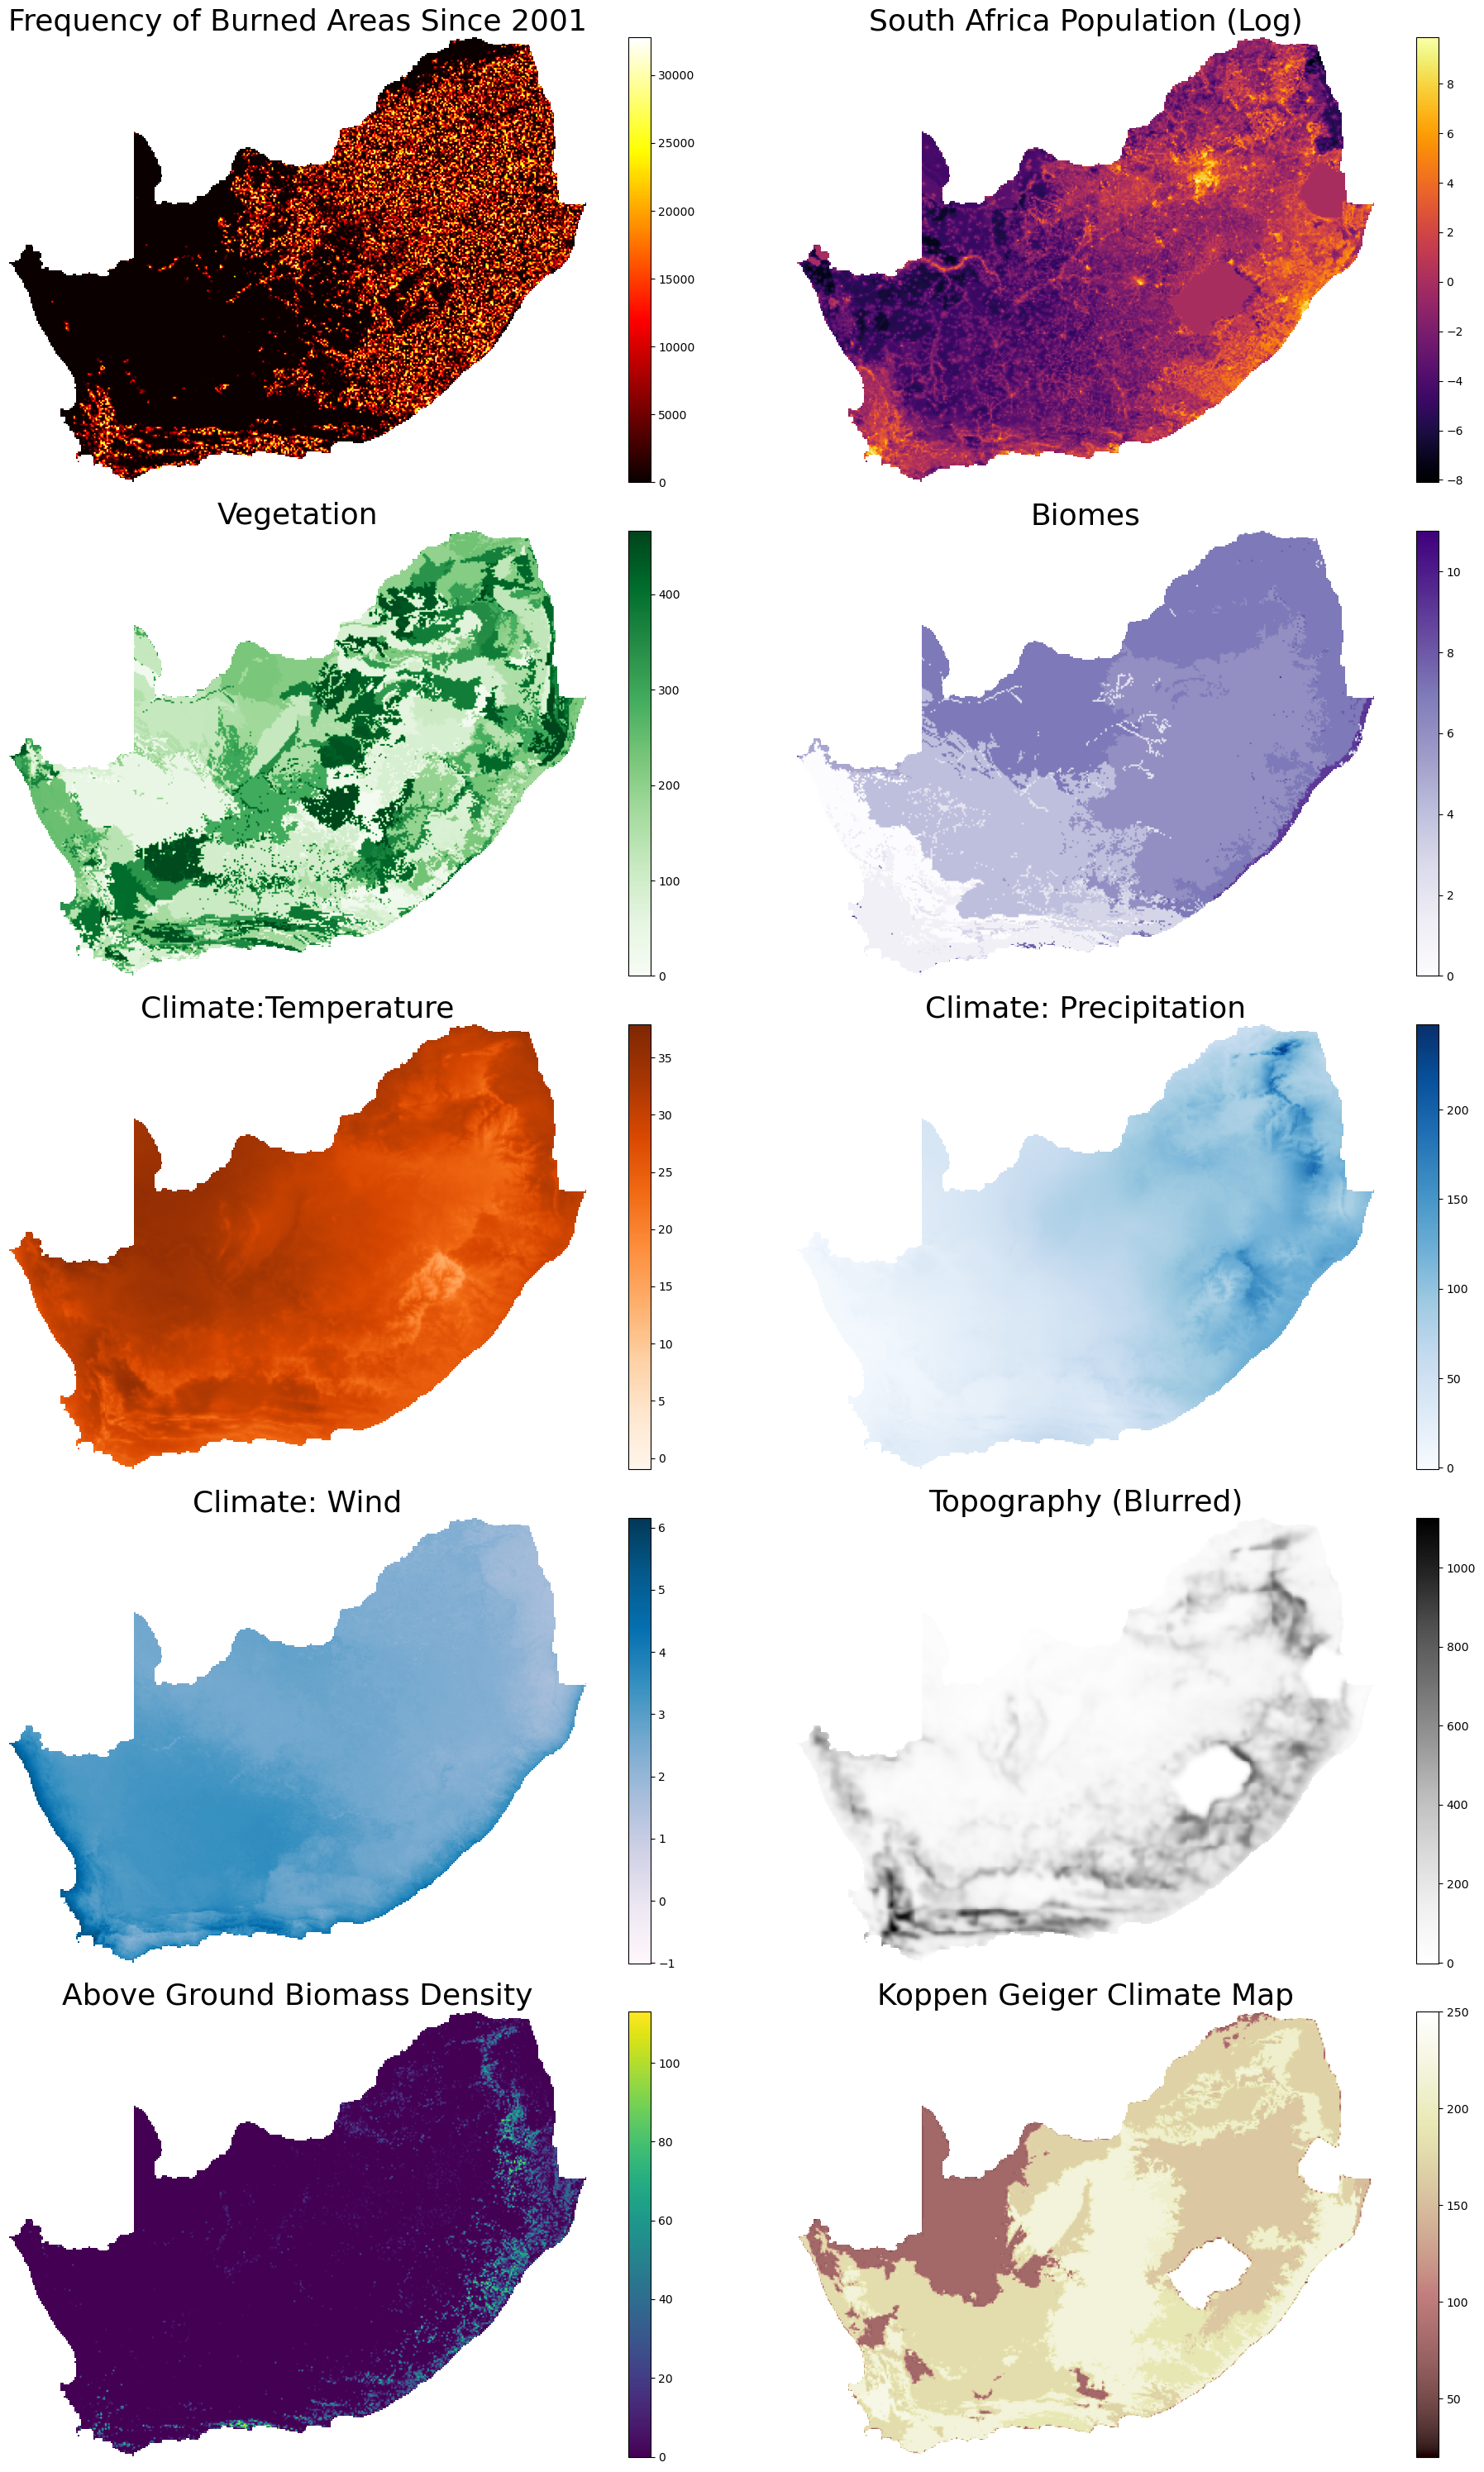

In [2]:
# Open the GeoTIFF file
with rasterio.open('data/predisposition/fire_area_predisposition.tif') as src:
    # Read the number of bands, which is 10 in this case
    number_of_bands = src.count

    # Predefined lists of titles and color maps, assuming you have at least 10 of each
    titles = ['Frequency of Burned Areas Since 2001', 'South Africa Population (Log)', 'Vegetation', 'Biomes', 'Climate:Temperature', 
              'Climate: Precipitation', 'Climate: Wind', 'Topography (Blurred)', 'Above Ground Biomass Density', 'Koppen Geiger Climate Map']
    color_maps = ['hot', 'inferno', 'Greens', 'Purples', 'Oranges', 
                  'Blues', 'PuBu', 'Greys', 'viridis', 'pink']

    # Create a figure with subplots in a 5x2 grid
    fig, axs = plt.subplots(5, 2, figsize=(20, 30))  # Adjust figsize as needed
    
    # Read all band data
    band_data = [src.read(band) for band in range(1, number_of_bands + 1)]

    # Set pixels to NaN where band 4 has a value of -1
    mask = band_data[3] == -1  # Band 4 is at index 3 in the list
    for band in band_data:
        band[mask] = np.nan  # Set to nan

    # Loop through each band using enumerate to keep the right axis order
    for idx, data in enumerate(band_data):
        # Get the current axis
        ax = axs[idx // 2, idx % 2]  # Calculate row and column index

        # Display the band data using predefined titles and color maps
        image = ax.imshow(data, cmap=color_maps[idx])
        ax.set_title(titles[idx], fontsize=26)
        ax.axis('off')

        # Add a color bar for each subplot
        fig.colorbar(image, ax=ax)

    # If there are subplots without data (e.g., if the number of bands is not a multiple of the grid size), remove their axes
    for i in range(number_of_bands, len(axs.flatten())):
        fig.delaxes(axs.flatten()[i])

    # Show the plots
    plt.tight_layout()
    plt.show()

The following is an included example of the Julian Day dataset, the 2017 year in particular. The code used applies the appropriate map projections and cropping. Brighter regions indicate fires that happened later in the calendar year - each colour is roughly the date at which the fire began

South Africa bounds in decimal degrees (W, S, E, N):
(16.454444444444444, -34.833333333333336, 32.891666666666666, -22.12527777777778)


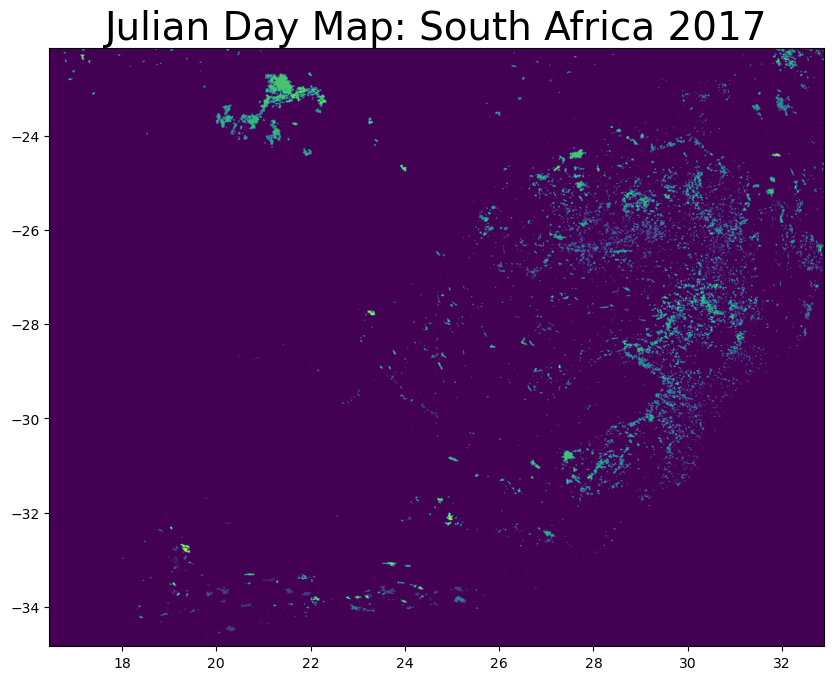

In [3]:
from rasterio.mask import mask

# Convert DMS to Decimal Degrees
def dms_to_dd(degrees, minutes, seconds, direction):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60)
    if direction in ['S', 'W']:
        dd *= -1
    return dd

# South Africa Bounds in DMS
upper_bound_north_dms = (22, 7, 31, 'S')
left_bound_west_dms = (16, 27, 16, 'E')
lower_bound_south_dms = (34, 50, 0, 'S')
right_bound_east_dms = (32, 53, 30, 'E')

# Convert to Decimal Degrees
upper_bound_north = dms_to_dd(*upper_bound_north_dms)
left_bound_west = dms_to_dd(*left_bound_west_dms)
lower_bound_south = dms_to_dd(*lower_bound_south_dms)
right_bound_east = dms_to_dd(*right_bound_east_dms)

# Create the bounding box for South Africa
south_africa_bounds = (left_bound_west, lower_bound_south, right_bound_east, upper_bound_north)

print("South Africa bounds in decimal degrees (W, S, E, N):")
print(south_africa_bounds)

# Define the bounding box for South Africa - these are approximate coordinates
south_africa_bounds = (16.452, -34.838, 32.896, -22.136)

# Create a bounding box geometry
bbox = box(*south_africa_bounds)

# Convert the bounding box to a GeoDataFrame
gdf = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs="EPSG:4326")

# Ensure the GeoDataFrame uses the same CRS as the raster data
gdf = gdf.to_crs(crs="EPSG:4326")

# Open the original GeoTIFF
with rasterio.open('data/jay_day/jay_day_2017.tif') as src:
    # Make sure we're using the same CRS for both the raster and the mask
    if gdf.crs != src.crs:
        gdf = gdf.to_crs(src.crs)

    # Crop the image using the bounding box
    out_img, out_transform = mask(src, gdf.geometry, crop=True)

    # Plot the result
    plt.figure(figsize=(10,10))
    plt.title("Julian Day Map: South Africa 2017", fontsize=28)
    show(out_img, transform=out_transform)
    plt.show()

# 4. Methodology <a class="anchor" id="methods"></a>

Upon completing the preprocessing phase, we strategically merged the assorted datasets into a singular, consolidated format using GeoTIFF layers, a commonly employed G.I.S. technique. In the subsequent phase of our methodology, we addressed the modeling tasks by transforming the GeoTIFF files into a more analyzable form. By unfolding the TIFF files and flattening the arrays, we converted each pixel into an individual observation point. This step allowed us to interpret the multi-layered geospatial data as a tabular dataset where each pixel is treated as an independent observation and each layer corresponds to a distinct feature. This approach is the cornerstone of our modeling strategy, enabling us to assess each grid cell on an individual basis, predicated purely on its intrinsic environmental and meteorological attributes.


Our sampling technique involved the random selection of 5x5 grid cells across the South African landscape to serve as the basis for our predictive models. This sampling strategy was employed to ensure a representative and statistically significant dataset that could inform our models with a high degree of accuracy. The comparison betwen training and validation performance was deemed of key importance for communicating model objectivity in a field where decisions are often made subjectively.

We developed two distinct models as part of our study. The first model was dedicated to predicting fire predisposition, utilizing a cumulative record of fire incidents since the year 2010. The second model focused on the potential extent of fire spread, incorporating granular daily weather data to enhance the predictive precision regarding the scale and severity of fire events. We knowingly divided our modeling efforts between these two tasks, recognizing the importance of both in the holistic assessment of fire risk. However, by seperating our attention, neither model is necessarily perfected.

We now discuss more detailed implementation regarding the intricate aspects of model design, feature selection, and algorithmic choices, ensuring transparency and reproducibility of our research findings.

## 4.1 Fire Predisposition <a class="anchor" id="fire_pre"></a>

The consolidated dataset comprises of all 10 layers, unified into a single GeoTIFF (TIF) file, where each band corresponds to an individual dataset. Each pixel of the consolidated TIFF file is considered as an instance with 10 attributes -- each attribute corresponding to a band.
The contents of each band are as follows:

1) - Fire Area Predisposition (float)
2) - Log Population (float)
3) - Vegetation Type (categorical)
4) - Biome Type (Categorical)
5) - Avg. Summer Max Temperature (float)
6) - Avg. Summer Precipitation (float)
7) - Avg. Summer Wind Speed (float)
8) - Smoothed Topology (float)
9) - Above Ground Biomass Density (float)
10) - Koppen Geiger Climate (categorical)

Instances lacking information on vegetation type and biome type are excluded due to their location falling outside the South Africa's boundaries. Additionally, instances with missing values for Fire Area are eliminated, given the significant skewness in Fire Area data. Next, we filled in missing data for Avg. Max Summer Temperature, and Precipition using interpolation. However, the topology dataset had too many missing values to remove all such instances, so these points were labelled as missing since our chosen model is equipped to manage such missing values.

In [4]:
#This code shows the first portion of missing value handling
#The full code is found in "04_model_fire_area.ipynb"
num_bands = 10
# Load the GeoTIFF file
file_path = 'data/predisposition/fire_area_predisposition.tif'
with rasterio.open(file_path) as src:
    # Read the raster data as separate bands
    band_data = [src.read(i+1) for i in range(num_bands)]

    rows, cols = np.indices((src.height, src.width))

# Convert the bands into a 2D array format (n_samples, n_features)
data_reshaped = np.dstack(band_data + [rows, cols]).reshape(-1, num_bands + 2)

# Create a DataFrame
df = pd.DataFrame(data_reshaped, columns=[
    'Fire_Area', 'Population', 'Vegetation_Type', 'Biome_Type',
    'Avg_Summer_Temp', 'Precipitation', 'Wind', 'Topology', 'Koppen', 'Biomass_Density', 'Row_Index', 'Col_Index'
])

# Remove instances with missing values for Vegetation Type and Biome Type
# Since missing values are indicated by -1 for these bands
df_filtered = df[(df['Vegetation_Type'] != -1) & (df['Biome_Type'] != -1) & (df['Fire_Area'] != -1)]

#
df_filtered.head()

,Fire_Area,Population,Vegetation_Type,Biome_Type,Avg_Summer_Temp,Precipitation,Wind,Topology,Koppen,Biomass_Density,Row_Index,Col_Index
294,0.0,3.776213,385.0,2.0,32.489998,56.5,2.075,74.0,0.0,250.0,0.0,294.0
295,0.0,3.729635,236.0,7.0,32.415001,56.0,1.950,86.0,0.0,250.0,0.0,295.0
296,0.0,-0.214348,192.0,7.0,32.377998,54.5,2.225,92.0,5.0,250.0,0.0,296.0
297,0.0,0.178347,385.0,2.0,32.483997,55.0,2.175,85.0,0.0,250.0,0.0,297.0
651,0.0,2.297181,385.0,2.0,32.932999,56.5,2.225,34.0,0.0,250.0,1.0,284.0


Afterward, we proceeded to eliminate under-represented vegetation categories, specifically removing any instance sharing a category with five or fewer other instances -- with the aim of eliminating noise. The dataset underwent division into training and testing sets, with a testing set sampling rate set at 0.2. The chosen model was a [Catboost Regressor](https://catboost.ai/) [4]  -- an efficient regression tree implementation designed to natively handle categorical features without one hot encoding. Notably [Sci-kit Learn's](https://scikit-learn.org/stable/modules/classes.html) Decision Tree implementation requires one-hot encoding. This property of catboost was desirable since the Vegetation Dataset has an excessively large number of categories, and would require the addition 466 new features corresponding to each category. 

CatBoost is an open-source gradient boosting library designed specifically for categorical data. The library is versatile, supporting classification, regression, and ranking tasks. 'CatBoost' derives from its name from 'Cat' for handling categorical variables, and 'Boost' for gradient boosting. Ensemble methods, by their nature, are well-suited to dealing with noise because they combine the predictions of several base estimators to improve robustness over a single estimator. The combination of Catboost's ability to cope with noise with its ability to handle categorical data made it an ideal choice.


The CatBoostRegressor was configured with selected hyperparameters: 500 epochs, a learning rate of 0.15, a tree depth of 6, evaluation metric set to root mean square error, and a fixed random seed of 42 for result reproducibility.

To identify the optimal set of hyperparameters, the following parameter grid was established:

- **Tree depth:** 4, 6, 8
- **Learning rate:** 0.03, 0.1, 0.15
- **L2 leaf regularization:** 1, 3, 5
- **Iterations:** 500, 1000

CatBoost is furnished with a grid search function, employed here to identify the optimal hyperparameters from the parameter grid. The search revealed that the most effective parameters were a tree depth of 8, regularization strength set to 3, 1000 iterations, and a learning rate of 0.1. These chosen hyperparameters resulted in a root mean squared error of 2.62, a mean squared error on the testing set of 2.62, and an R<sup>2</sup> score of 0.66. Importantly, the order of feature importances remained unchanged.

The analysis revealed that precipitation emerged as the most crucial feature, commanding an importance of 27.34%. Subsequently, average summer temperature, topology, and vegetation type followed suit, boasting importances of 15.92%, 13.68%, and 13.46%, respectively. The model's performance metrics were recorded with a mean squared error of 6.89 and an R<sup>2</sup> score of 0.656. An experiment involving undersampling instances where Fire Area was equal to 0.0 was conducted, but it was deemed detrimental to the model's performance. The below images show the distribution of the Fire Area variable before and after removing 50% of the instances with Fire Area = 0.0. The rationale behind this was that tdistribution of Fire Data was seriously skewed and should be balanced, however the outcome of this was net negative performance.

## 4.2 Burned Area <a class="anchor" id="fire_area"></a>

The second goal was to model the spread of a fire, should one occur in a given area. From the Jay Day (Julian Day) dataset, we obtained the initial observed date of each wildfire in the years 2010-2018, as well as the number of 250x250 meter sections were affected by each fire. Fires that correspond to fewer than 16 burned sections (or 1 square kilometer of burned area) were filtered out, to reduce noise introduced by small, controlled or garbage fires picked up in the satelite data. This yielded a dataset of fire-dates and locations, along with the total burned area of each fire, scaled by 16 to produce the measure in square kilometers.
Additionally, the environment and population data gathered for South Africa was combined with daily weather conditions at each fire location.

To obtain a general framework of the problem, the timestamp and coordinate features were not used in modeling. The final set of predictors was thus population, vegetation type, biome, topography, biomass, Kopper climate, average daily temperature, minimum daily temperature, maximum daily temperature, total daily precipitation and average windspeed.

Notably, our dataset exhibited a significant imbalance: nearly 90% of the fire instances affected areas smaller than 10 square kilometers. While these smaller fires form the majority of the observations, it is the remaining 10%—those fires covering areas between 10 and 150 square kilometers—that pose a more severe threat and, therefore, hold particular significance for our model. These larger fires, although less frequent, are pivotal in understanding and predicting the most impactful wildfire events.

To address this imbalance and the associated noise, we implemented an undersampling strategy on the majority 'class'— the smaller fires. 'Class' here refers to the two equal frequency bins made to understand the imbalance. We randomly removed samples from the majority class to achieve parity with the larger fire instances (the minority class), thus ensuring an equal representation in our training dataset. This approach not only balanced our dataset but also yielded a dual advantage: it reduced the computational load and cost without compromising the integrity of our regression target.

For the model architecture, we employed the robust [XGBoost](https://xgboost.readthedocs.io/en/stable/) [5] framework, which facilitates both random forest and gradient boosting methodologies. Optimal hyperparameters, including the choice of the base tree learner and the specifications for the size of the forest and boosting rounds, were determined through a 5-fold cross-validation grid search on the training set. We evaluated model performance using the coefficient of determination R<sup>2</sup> and the Mean Absolute Error (MAE). Upon finalizing the training phase, we subjected our model to a rigorous evaluation on the test set, comprising 30% of the data, to affirm its predictive power and readiness for application in strategic fire management and response planning.

In [5]:
fire_risk = pd.read_csv('data/fire_risk.csv', parse_dates=['time'])
fire_risk['burned area'] = fire_risk['burned area']
fire_risk['vegetation'] = fire_risk['vegetation'].astype('category')
fire_risk['biome'] = fire_risk['biome'].astype('category')
fire_risk['climate'] = fire_risk['climate'].astype('category')

print(fire_risk.shape)
fire_risk.head(5)

(337325, 14)


,time,year_day,population,vegetation,biome,topography,biomass,climate,tavg,tmin,tmax,prcp,wspd,burned area
0,2018-09-18,261,-5.052179,192.0,7.0,121.0,7.0,170.0,22.262836,13.090812,31.201169,0.000000,10.059855,4.8750
1,2018-09-19,262,-5.052179,192.0,7.0,121.0,7.0,170.0,21.162242,13.525081,29.760529,0.000000,13.591260,26.4375
2,2018-09-23,266,-5.052179,192.0,7.0,121.0,7.0,170.0,21.012723,15.863721,27.924992,2.858114,14.929531,1.0625
3,2018-09-26,269,-5.052179,192.0,7.0,121.0,7.0,170.0,22.112028,13.859260,30.820909,0.000000,9.198509,1.0000
4,2018-09-19,262,-4.933649,192.0,7.0,104.0,7.0,170.0,21.473880,13.772980,29.972535,0.006816,14.215749,26.2500


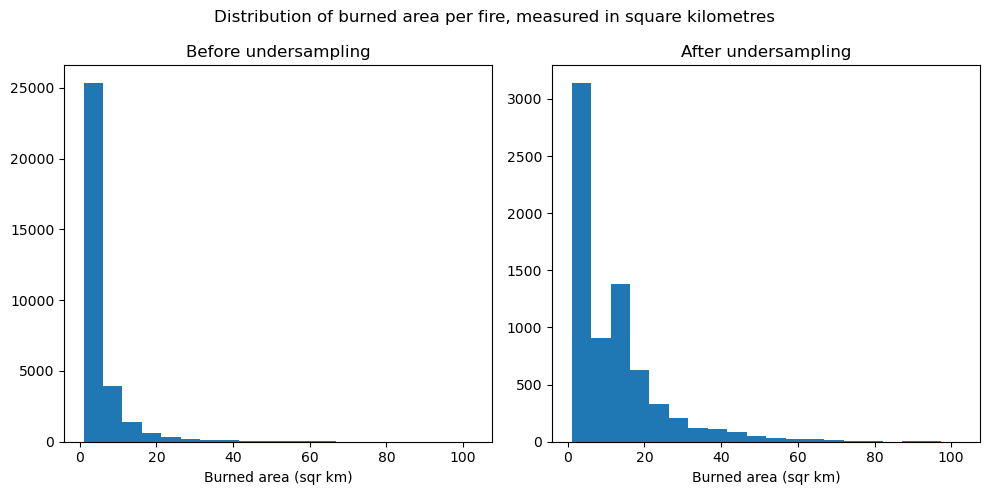

In [6]:
# For discussion purposes we'll focus on the data from 2017
fire_risk = fire_risk[fire_risk['time'].dt.year == 2017]
np.random.seed(10)
sample_thresh = 10

# Undersample such that number of fires <= 10 sqr km is the same as number of fires > 10 sqr km
major_class = np.where(fire_risk['burned area'] <= sample_thresh)[0]
minor_classes = np.where(fire_risk['burned area'] > sample_thresh)[0]
sample_size = minor_classes.shape[0]
under_sampled = list(minor_classes) + list(np.random.choice(major_class, size=sample_size, replace=False))

fire_risk_sub = fire_risk.iloc[under_sampled]

fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].hist(fire_risk['burned area'], bins=20)
axes[1].hist(fire_risk_sub['burned area'], bins=20)
axes[0].set_xlabel("Burned area (sqr km)")
axes[1].set_xlabel("Burned area (sqr km)")
axes[0].set_ylabel("Frequency")
axes[0].set_ylabel("")
axes[0].set_title("Before undersampling")
axes[1].set_title("After undersampling")

plt.suptitle("Distribution of burned area per fire, measured in square kilometres")
plt.tight_layout()

Our final selected XGBoost model, which comprised 100 trees per forest and was boosted 50 times.

# 5. Results <a class="anchor" id="results"></a>
The following section provides some of the key findings and results generated from our modelling. The section is divided according to the two employed modle
## Predisposition Model <a class="anchor" id="results1"></a>

The full code to perform the validation steps followed is supplied within our pipeline. Included here is the final selected catboost model, which is then trained and tested on independent data subsets. Discussion regarding the results is presented following the execution of the following code cell:

In [7]:
categorical_features_indices = [1, 2, 7]
df_filtered_vegetation = pd.read_csv('data/filtered_vegetation.csv', index_col=0)

df_filtered_vegetation['Log_Fire_Area'] = np.log1p(df_filtered_vegetation['Fire_Area'])

X_train, X_test, y_train, y_test = train_test_split(
    df_filtered_vegetation.drop(['Fire_Area', 'Log_Fire_Area', 'Row_Index', 'Col_Index'], axis=1),
    df_filtered_vegetation['Log_Fire_Area'],
    test_size=0.2,
    random_state=42
)

# Define the dataset Pool
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
test_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)

cat_model = CatBoostRegressor(depth = 8, l2_leaf_reg = 3, learning_rate = 0.1, eval_metric='RMSE', random_seed=42, iterations=1000, verbose=100)
cat_model.fit(train_pool)

# Get predictions
y_pred = cat_model.predict(test_pool)
y_pred_train = cat_model.predict(train_pool)

# Calculate MSE and R^2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Same for Training Set
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Get feature importances
feature_importances = cat_model.get_feature_importance()
feature_names = X_train.columns
feature_importance_dict = dict(zip(feature_names, feature_importances))

print("MSE on training set:", mse_train)
print("MSE on test set:", mse)
print("R^2 on training set:", r2_train)
print("R^2 on test set:", r2)
print("Feature Importances:")
for name, importance in feature_importance_dict.items():
    print(f"{name}: {importance:.2f}%")

0:	learn: 4.2441642	total: 59.5ms	remaining: 59.4s
100:	learn: 2.6199610	total: 660ms	remaining: 5.87s
200:	learn: 2.5130055	total: 1.28s	remaining: 5.11s
300:	learn: 2.4431955	total: 1.94s	remaining: 4.49s
400:	learn: 2.3820960	total: 2.58s	remaining: 3.85s
500:	learn: 2.3323853	total: 3.21s	remaining: 3.19s
600:	learn: 2.2825384	total: 3.85s	remaining: 2.56s
700:	learn: 2.2409086	total: 4.49s	remaining: 1.92s
800:	learn: 2.2011490	total: 5.13s	remaining: 1.27s
900:	learn: 2.1633737	total: 5.76s	remaining: 633ms
999:	learn: 2.1295817	total: 6.41s	remaining: 0us
MSE on training set: 4.984307063118496
MSE on test set: 6.754832316784692
R^2 on training set: 0.752499707313153
R^2 on test set: 0.6638845104990114
Feature Importances:
Population: 8.93%
Vegetation_Type: 12.69%
Biome_Type: 8.28%
Avg_Summer_Temp: 15.09%
Precipitation: 21.40%
Wind: 9.35%
Topology: 14.41%
Koppen: 2.82%
Biomass_Density: 7.03%


The `learn` metric represents the Root Mean Square Error (RMSE) on the training set after a certain number of iterations. RMSE is a standard measure to evaluate the performance of a regression model, with a lower value indicating a better fit. The time after `total` indicates how long the training took up to that point, and `remaining` estimates how much time is left until the training is complete.

The performance of the model on both the training and test sets is given by the MSE (Mean Squared Error) and R<sup>2</sup>  (coefficient of determination) metrics: The MSE on the training set is approximately 4.98, and on the test set, it is approximately 6.75. MSE is a measure of the average squared difference between the observed actual outcoming values and the values predicted by the model, a lower MSE value for the training set compared to the test set suggests the model may be fitting the training data well but not performing as strongly on unseen data, indicating a potential overfit. However, whilst this overfitting appears to occur, best validation performance was found at this complexity, indicating that whilst the model was fitting noise, it also did manage to learn some underlying patterns. The R<sup>2</sup>  metric provides a measure of how well the model captures the variance of the dataset. An R<sup>2</sup>  of 1 indicates perfect prediction. It can be seen that the R<sup>2</sup>  on the testing set is reasonably high, which means the model explains 66% of the variance in the testing data. This is impressive given the noise inherant in the dataset. Once again, traces of overfitting are also evident.

The final analysis details the feature importances, which indicate how much each feature contributes to the model's predictions:
`Population`, `Vegetation_Type`, `Biome_Type`, `Avg_Summer_Temp`, `Precipitation`, `Wind`, `Topology`, `Koppen`, and `Biomass_Density` are the features used by the model, and their importances are expressed as percentages. We found that `Precipitation` is the most influential feature, with an importance of 21.40%, followed by `Avg_Summer_Temp` (15.09%) and `Topology` (14.41%). The prevelance of these features underscores the importance of climate to wildfire behaviour and validates the currently employed FDI measure. `Koppen` (climate classification) displayed the lowest importance at 2.82%, indicating it has the least influence on the model's predictions among the listed features. This is likely due to a large feature correlation with the other climate features.

## Visualisation of Predicted Log Fire Area for the Full Processed Dataset
To understand the use and utility of our provided model, we produced a visualization by projecting the predicted instances back onto a TIFF file -- predictions for the full dataset. The provided visualization thus comes with the very important caveat of data leakage, a large portion of the predictions made in the visual are on training samples. However, this was not deemed a critical issue, the model would likely be applied in a similar fashion in the real world, by training on the full dataset. This visualization gives an idea of what the predictions look like.

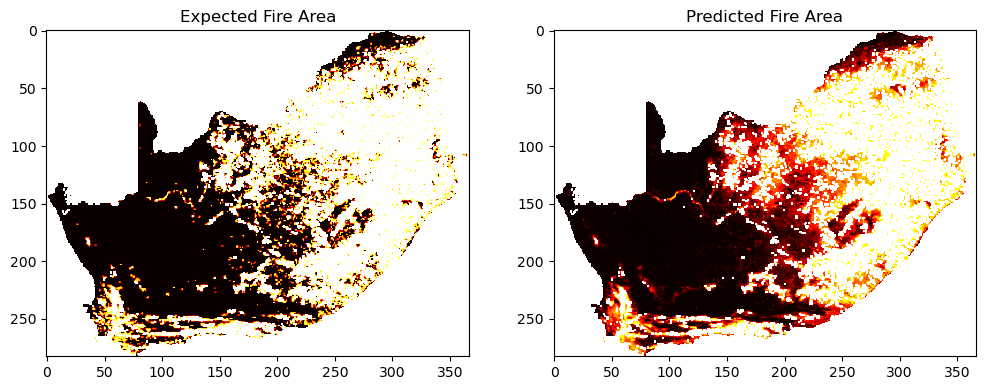

In [8]:
actual_fire_area = df_filtered_vegetation['Log_Fire_Area'].to_numpy()
predicted_fire_area = cat_model.predict(df_filtered_vegetation.drop(['Fire_Area', 'Log_Fire_Area', 'Row_Index', 'Col_Index'], axis=1))

# Open the original TIFF to get the metadata
with rasterio.open(file_path) as src:
    meta = src.meta
    nodata_value = meta['nodata']

    # Initialize arrays with the nodata value
    expected_fire_area_raster = np.full((src.height, src.width), fill_value=nodata_value, dtype=src.meta['dtype'])
    predicted_fire_area_raster = np.full_like(expected_fire_area_raster, fill_value=nodata_value)

# Fill in the expected and predicted values using the indices
for idx, ((row, col), actual, predicted) in enumerate(zip(df_filtered_vegetation[['Row_Index', 'Col_Index']].itertuples(index=False, name=None), actual_fire_area, predicted_fire_area)):
    try:
        expected_fire_area_raster[int(row), int(col)] = actual
        predicted_fire_area_raster[int(row), int(col)] = predicted
    except IndexError as e:
        print(f"Error at index {idx}: row={row}, col={col}")
        print(str(e))
        break  # Stop the loop at the first error

# Save the rasters as TIFFs
expected_tif_path = 'expected_fire_area.tif'
predicted_tif_path = 'predicted_fire_area.tif'

with rasterio.open(expected_tif_path, 'w', **meta) as dst:
    dst.write(expected_fire_area_raster, 1)

with rasterio.open(predicted_tif_path, 'w', **meta) as dst:
    dst.write(predicted_fire_area_raster, 1)

# Visualize the rasters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(expected_fire_area_raster, cmap='hot', vmin=0)
ax1.set_title('Expected Fire Area')
ax2.imshow(predicted_fire_area_raster, cmap='hot', vmin=0)
ax2.set_title('Predicted Fire Area')
plt.show()

The comparison between the model's predicted fire map and the target map of actual historical fire incidents reveals a high degree of similarity, affirming the model's effectiveness. Notably, the model's predictions exhibit a smoother distribution of fire-prone areas, filling in gaps where no fires have been recorded historically. This smoothing effect is particularly evident in the Western Cape and the regions above the Cape Fold Mountains, suggesting a more uniform susceptibility to fire risk across the landscape. It is crucial to recognize that the model's identification of additional fire-risk areas does not necessarily point to inaccuracies; rather, it aligns with our goal of developing a generalizable predictive procedure. By highlighting areas that have not experienced fires but exhibit environmental conditions conducive to fire, the model fulfills its intended purpose—to serve as a tool for risk assessment, rather than merely replicating past data.

This outcome underscores the model's utility. Although it draws heavily from the training set, it does not merely mimic it but instead makes informed predictions. Such predictive behavior demonstrates the model's confidence in identifying fire-risk areas, which may have previously been overlooked. The essence of this research extends beyond the pursuit of perfect replication of known fire incidents. A model that could merely replicate past data would offer no new insights, as that information is already available. The inaccuracies of the catboost model offer insights as to disagreeable regions, and regions for which more information should be obtained. The interpretation and transparency of these visual results are of critical importance. The interpretability and clarity of these visual predictions are paramount, as they provide actionable intelligence for fire management and mitigation strategies.

## Burned Area Model <a class="anchor" id="results2"></a>

Our final XGBoost model demonstrated a clear discrepancy between training and testing performance. Specifically, the model achieved a notably lower error rate during training compared to testing. This pattern of divergence was also observed during the hyperparameter tuning phase; as the complexity of the model increased, there was a consistent reduction in error rates for both training and validation datasets. However, the rate of decline was more pronounced for the training error, suggesting a potential overfit to the training data. Upon a more detailed examination of the model's performance on the full test set, we recorded a test error of approximately 7.2 (square kilometers), accompanied by an R<sup>2</sup> value of 0.46. Demonstrated below is a mock example, trained only on the training data from 2017 and only the tested on the testing set of 2017. This was done in light of the exceedingly large datasets.

In [9]:
params = {
    "colsample_bynode": 0.8,
    "learning_rate": 0.8,
    "num_parallel_tree": 50,
    "objective": "reg:squarederror",
    "subsample": 0.8,
    "max_cat_threshold": 50,
    "booster": 'gbtree',
    "lambda": 0,
    "alpha": 20.0,
    "max_depth": 12
}
num_bst = 50

predictors = ['population', 'vegetation', 'biome', 'topography', 'biomass', 'climate', 'tavg', 'tmin', 'tmax', 'prcp', 'wspd']
target = 'burned area'
data_X = fire_risk_sub[predictors]
data_Y = fire_risk_sub[target]

train_X, test_X, train_Y, test_Y = train_test_split(data_X.to_numpy(), data_Y.to_numpy(), test_size=0.3, random_state=42, shuffle=True)

# Sample training and testing on subset of data
train_mat = xgb.DMatrix(train_X, train_Y, enable_categorical=True)
test_mat = xgb.DMatrix(test_X, test_Y, enable_categorical=True)

xgb_small = xgb.train(params, train_mat, num_boost_round=num_bst)
train_pred = xgb_small.predict(train_mat)
test_pred = xgb_small.predict(test_mat)
print(f"Small trained model, training R2 {round(r2_score(train_Y, train_pred), 4)} and MAE {round(mean_absolute_error(train_Y, train_pred), 3)}")
print(f"Small trained model, testing R2 {round(r2_score(test_Y, test_pred), 4)} and MAE {round(mean_absolute_error(test_Y, test_pred), 3)}")

Small trained model, training R2 0.9906 and MAE 0.844
Small trained model, testing R2 0.5157 and MAE 6.095


Although this level of accuracy is modest, it is important to recognize the improvement in model performance when focusing on the 2017 data subset. This enhancement could be attributed to a reduction in noise, achieved by narrowing the scope of the analysis, or it might reflect a closer alignment between the distributions of the training and test datasets for that particular year. The following mock examples load the fully trained XGBoost model, and test on the seperated 2017 testing set.

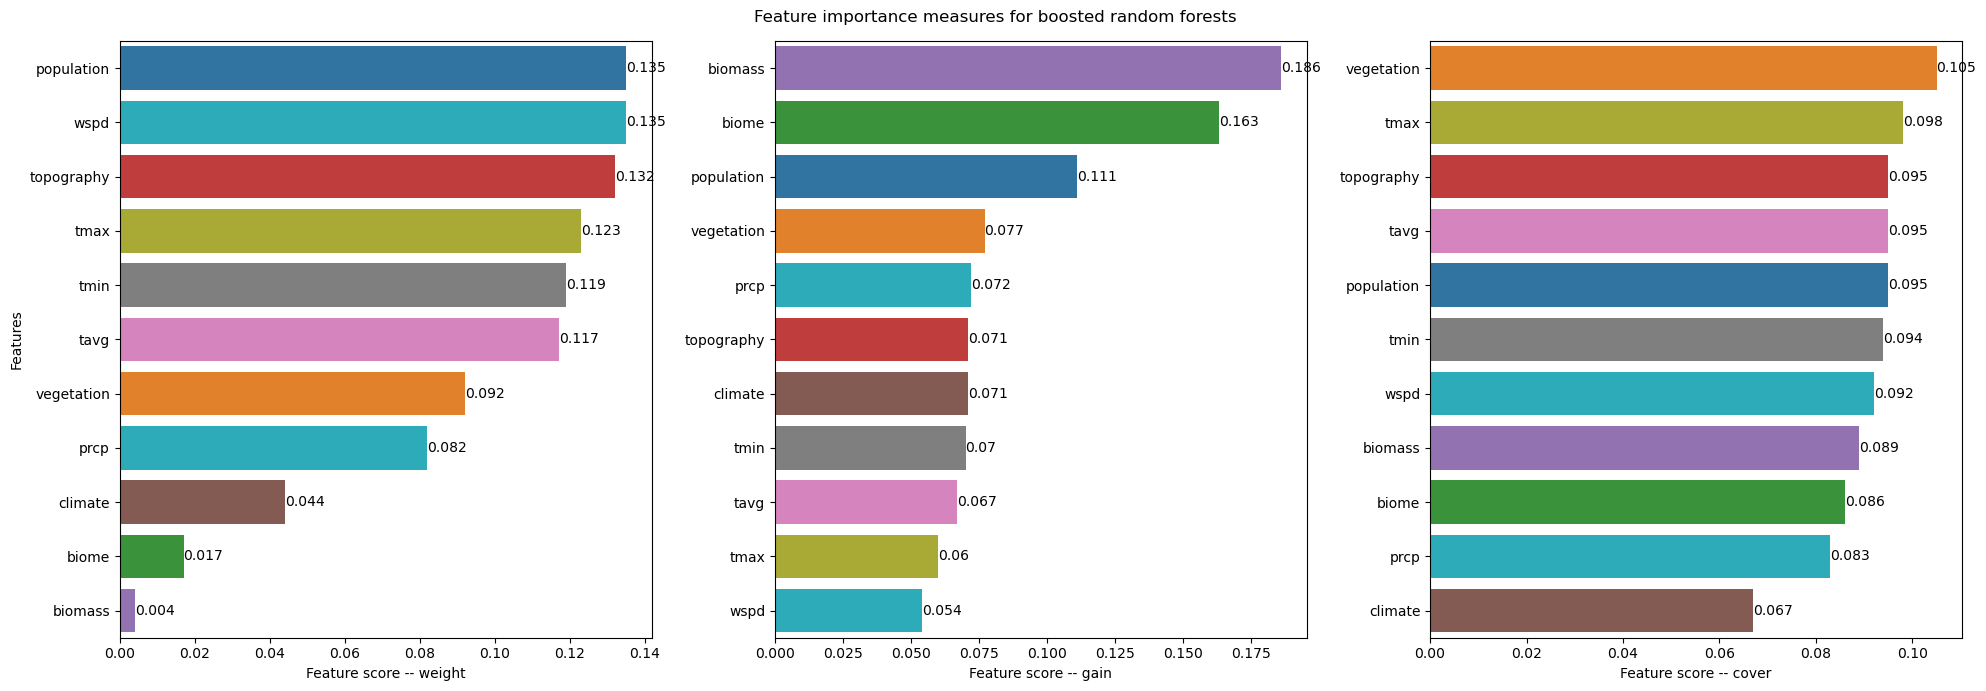

In [10]:
xgb_full = xgb.Booster()
xgb_full.load_model('data/burned_area_model.json')

# SKLearn-like model instance
xgb_estim = xgb.XGBRegressor()
xgb_estim._Booster = xgb_full

fig, axes = plt.subplots(1, 3, figsize=(20,7))
colors = plt.cm.tab10(np.linspace(0, 1, len(predictors)))

for i, tp in enumerate(['weight', 'gain', 'cover']):

    importance = list(xgb_full.get_score(importance_type=tp).values())
    importance = np.array(importance) / sum(np.array(importance))
    sort_ix = importance.argsort()[::-1]
    importance = importance[sort_ix]
    feat_order = np.array(predictors)[sort_ix]
    cm = colors[sort_ix]

    ax = sns.barplot(x=np.round(importance, 3), y=feat_order, palette=cm, ax=axes[i])
    ax.bar_label(ax.containers[0])
    axes[i].set_xlabel(f"Feature score -- {tp}")

axes[0].set_ylabel("Features")
plt.suptitle("Feature importance measures for boosted random forests")
plt.tight_layout()

In evaluating the significance of different features within our XGBoost model, we employed three distinct metrics of feature importance:

1. **Weight:** This is the count of the number of times a feature is used to split the data across all trees.
2. **Gain:** This represents the average gain of the feature when it is used in trees, reflecting the contribution of a feature to the model's predictive power.
3. **Cover:** This metric indicates the average number of samples affected by the feature across all splits in which it appears.

Our analysis revealed a relatively uniform distribution of coverage across all features, suggesting that each feature, on average, influences a similar number of data points when it is utilized in a split. However, both the weight and gain associated with the features exhibited more variation. Interestingly, we observed that while features such as biome and biomass density were infrequently utilized for splits (as indicated by their lower weight), the average gain from such splits was considerably high. This suggests that while occurrences of certain biomes and substantial quantities of fuel (biomass) may be less common within the dataset, they have a significant impact on the predictive accuracy when they do contribute to a split. This aligns with intuitive understanding, as both the presence of specific biomes and the availability of fuel are critical determinants of fire behavior, and in the case of bio fuel, the data is predominantly relevant only for forested regions.

The population feature emerged as highly influential, boasting a high weight and gain, indicating that it is frequently used for splits and contributes greatly to the model’s performance. Topography and maximum temperature are also prominent features, both showing large weights, which implies they are commonly used in splits. Moreover, these features have extensive coverage, signifying their impact on a larger number of samples within the dataset. Conversely, certain features such as climate classification and precipitation exhibited low overall importance. Despite this, when these features were used, they achieved a large gain, suggesting that in specific contexts, they can be highly informative for the model, albeit their instances of utility are rare within the current dataset structure.


The following example demonsrates the performance of the XGBoost model on the 2017 testing set. The observations are ordered according to their target burned area.

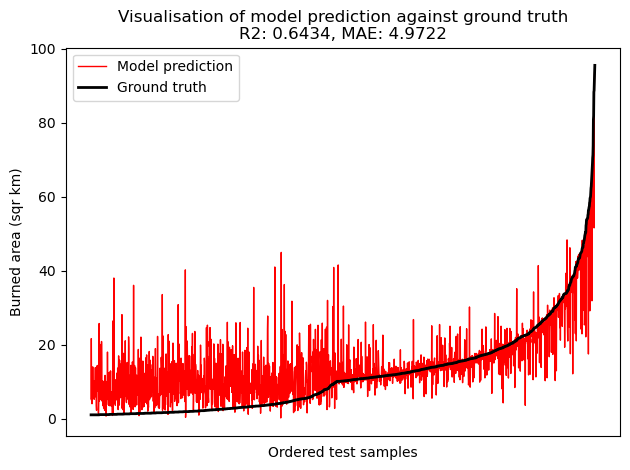

In [11]:
sub_pred = xgb_estim.predict(test_X)
test_pred = xgb_estim.predict(test_X)

sort_ix = test_Y.argsort()
order_Y = test_Y[sort_ix]
order_pred = sub_pred[sort_ix]

sns.lineplot(x=range(test_X.shape[0]), y=order_pred, color='red', linewidth=1, label="Model prediction")
sns.lineplot(x=range(test_X.shape[0]), y=order_Y, color='black', linewidth=2, label="Ground truth")

plt.title("Visualisation of model prediction against ground truth\n" + 
            f"R2: {round(r2_score(test_Y, test_pred),4)}, MAE: {round(mean_absolute_error(test_Y, test_pred),4)}")
plt.ylabel("Burned area (sqr km)")
plt.xticks([])
plt.xlabel("Ordered test samples")
plt.tight_layout()

Regarding the figure, we can see that the generization performance of the XGBoost model is significantly better than over the full dataset. This observation underscores the significance of dataset composition and the influence of temporal factors on model training and prediction. It suggests that refining the selection of training data to better mirror the conditions of the test set could potentially yield a more accurate model. Additionally, it emphasizes the necessity for continual refinement of the model to adapt to the evolving nature of the data and the environmental conditions associated with wildfire occurrences. Further, it can be seen that the performance of the model improved upon using the fully trained XGBoost model rather than solely on 2017, meaning that data externel to the 2017 year still proved valuable. This further indicates that the loss of performance is likely a result of the characteristics of the testing set, and the degree of outliers. It should be noted that the R<sup>2</sup> score is particularly susceptible to outliers.

The substantial gap reported between training and test errors indicates the complexity and unpredictability inherent in the problem of wildfire spread prediction. It appears that the training data, despite its depth, may not fully encapsulate the entire spectrum of variability within the problem we aim to model. Consequently, this limitation impedes our ability to construct a model with strong generalizability across diverse conditions and instances, due to both noise and outliers. However, even with a low degree of generelization, the selected parameters provided best overall validation performance.

The model tends to over-predict the extent of fire spread, a pattern that may stem from the inclusion of large fire events within the training dataset. Interestingly, the model's predictions become more accurate when applied to larger fires, suggesting that it has learned the characteristics of extensive burn areas more effectively than those of smaller fires. This trend could be a result of the model's underlying objective function, which is to minimize the squared error. Since large fires contribute disproportionately to the squared error, the boosting algorithm may focus on these outliers more, leading to an amplified influence on the model's learning process.

Consequently, this focus on larger fires might account for the model's subpar performance across the full dataset, particularly with smaller fires where it seems to underperform. When examining the 2017 data subset, which includes a notable number of significant fires, the model's predictions tend to exhibit greater alignment with the testing data. This improved fit may be a direct reflection of the model's tendency to better capture the dynamics of larger fires, which are more prevalent in this subset.

# 6. A Retrospective and the Way Forward <a class="anchor" id="forward"></a>

In retrospect, the application of Geographic Information Systems (GIS) and map data posed a distinctive challenge within our research. The intricate spatial relationships and interactions between varied features required a nuanced understanding of spatial data, one which we developed through the course of the research. We are content with our collection of features and the methodologies employed, particularly our novel approach in segregating risk factors and implementing the "Random Forest" method. The results rendered by our models were interesting, albeit highlighting evident areas for enhancement.

A significant obstacle in our modeling efforts stemmed from the inherent complexities of wildfires — most notably their stochastic and sporadic nature. Both objectives of modeling fire occurrence and spread presented considerable noise and unpredictability. Particularly challenging was the reliance on satellite data for modeling fire spread, given that contextual factors such as controlled burns and human intervention are not available. Regional differences in fire behavior, such as the contrast between grass fires in the Highveld and forest fires in the Garden Route, further compounded the modeling difficulty.

The influence of extreme outlier samples on model performance was notable; these outliers represented the largest fires and, consequently, were of significant importance. However, the outliers also tended to skew our models to over-estimate the burned area on average. Moving forward, a more extensive investment in refining the predictive capabilities of each model is warranted.

We are however satisfied with the selection of models considering the prevalence of categorical variables and the inherent noise within the dataset. Nevertheless, there remains a likelihood that superior, yet unexplored, modeling alternatives exist. The endeavor of modeling fire risk has revealed itself to be more complex than initially anticipated. This extends to data collection: more detailed and granular weather data could immensely enhance the accuracy of the fire spread model, although acquiring such data without cost is a considerable hurdle. We advocate for the academic community to explore more rigourous testing of predictive models, utilizing more methods to evaluate and investigate the ability of the proposed models to generalize.

Our findings suggest that expanding the informational context of each cell — possibly by integrating data from neighboring cells—could improve model accuracy. Employing image-based modeling structures, such as Convolutional Neural Networks (CNNs), might be advantageous in this regard. We recommend the integration of suitable encoding layers to handle the categorical features effectively. The pursuit of higher data granularity could also elevate the predictive performance, provided that sufficient computational resources are available.

We also maintain that modeling wildfire risk remains a critical concern. In the face of climate change and the increasingly arid South African landscape, events like the 2017 Knysna fires may not remain as isolated as they currently stand. Our research further highlights the urgency for advanced modeling and preparedness to mitigate the risks and impacts of such extreme events.

# Bibliography

1. Köppen, W., 1884: The thermal zones of the earth according to the duration of hot, moderate and cold periods and to the impact of heat on the organic world. Meteorologische Zeitschrift (republished 2011). 20 (3): 351–360.
2. Köppen, Wladimir (1918). "Klassification der Klimate nach Temperatur, Niederschlag and Jahreslauf". Petermanns Geographische Mitteilungen. Vol. 64. pp. 193–203, 243–24
3. Rubel, F.; Kottek, M (2011). "Comments on: 'The thermal zones of the Earth' by Wladimir Köppen (1884)". Meteorologische Zeitschrift. 20 (3): 361–365.
4. Prokhorenkova, L. and Gusev, G. and Vorobev, A. and Dorogush, A.V.  and Gulin, A. (2018). CatBoost: unbiased boosting with categorical features. In Proceedings of the 32nd International Conference on Neural Information Processing Systems (NIPS'18). Curran Associates Inc., Red Hook, NY, USA, 6639–6649.
5. Chen, T. and Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD '16). Association for Computing Machinery, New York, NY, USA, 785–794